# **[Social media fake news detection](https://)**

* What Is Fake News ?

Fake news has become a growing concern in recent years, as it poses a significant threat to public discourse and undermines the integrity of news and information sources. With the widespread use of social media and the ease of sharing information, it has become increasingly challenging to distinguish between real and fake news. The problem of fake news detection has gained significant attention.

* Project Introduction ?

For this project, I am using the ISOT fake news dataset as my main data source. At the same time, based on the original data, some new data were created and added using ChatGPT and GoogleNews. Following data preprocessing, I applied both traditional machine learning models and deep learning models for classification prediction. Subsequently, I compared their respective performances and summarized my findings.



---



# ***1.Loading libraries***

In [101]:
import os
import cv2
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import re
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device', device)

device cuda


In [102]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/FakeNewsDetection/Fdj/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).




---



# ***2. Loading the dataset***

For this project, I am using the ISOT fake news dataset as my main data source, which includes two categories of articles: fake and real news. The truthful articles were obtained from Reuters.com, a reputable news website, while the fake news articles were collected from unreliable websites flagged by fact-checking organizations such as Politifact and Wikipedia. The dataset includes various types of articles, with a majority of them focused on political and world news topics.

The dataset is comprised of two CSV files, namely True.csv and Fake.csv. The former includes over 12,600 articles from Reuters.com, while the latter contains more than 12,600 articles from different sources of fake news. 

At the same time, based on the original data, I used ChatGPT and GoogleNews to create ten new data to replace the beginning data of the original data set. The generalization of the model can be increased by adding new data, making the model more accurate for future data classification. (If time permits, I should collect more new data as a supplement, a larger data set will lead to better prediction quality...)

Each article in the dataset includes:
* article title,
* text,
* subject,
* date,
* type (REAL or FAKE)

In [103]:
# Loading the datasets
fake = pd.read_csv('Fake.csv')
real =pd.read_csv('True.csv')

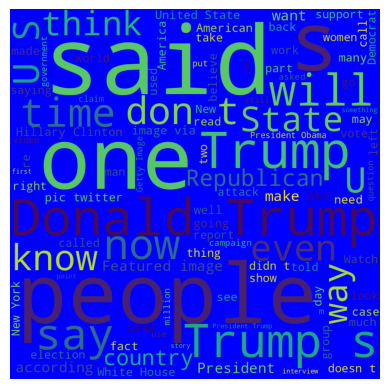

In [106]:
#Data Visualization

#Generating a word cloud of fake news data
from wordcloud import WordCloud  #The more the word appears, the largers the word font will be. 
wc = WordCloud(background_color="blue", max_words=100,
               max_font_size=256,
               random_state=42, width=1000, height=1000)
wc.generate(' '.join(fake['text']))
plt.imshow(wc)
plt.axis('off')
plt.show()

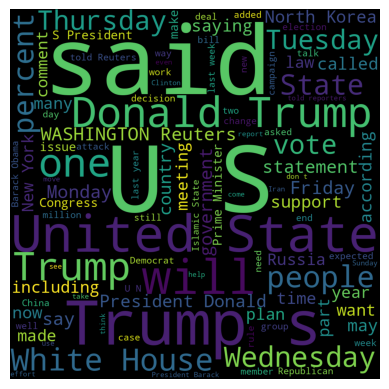

In [107]:
#Generating a word cloud of true news data
wc2 = WordCloud(background_color="black", max_words=100,
               max_font_size=256,
               random_state=42, width=1000, height=1000)
wc2.generate(' '.join(real['text']))
plt.imshow(wc2)
plt.axis('off')
plt.show()

In [108]:
#Add an identifier to distinguish between the merged datasets 0 is real and 1 is fake
real['Identifier'] = 0
fake['Identifier'] = 1

In [109]:
#Merge real and fake dataset
data = pd.concat([real, fake],axis=0,ignore_index=True)
data

,title,text,subject,date,Identifier
0,CDC Releases New Guidelines for COVID-19 Vacci...,The Centers for Disease Control and Prevention...,healthNews,8-Mar-21,0
1,NASA's Perseverance Rover Successfully Lands o...,"NASA's latest Mars rover, Perseverance, has su...",scienceNews,18-Feb-21,0
2,President Biden Signs $1.9 Trillion COVID-19 R...,President Joe Biden has signed a $1.9 trillion...,politicsNews,11-Mar-21,0
3,"House gives final approval to tax bill, delive...",WASHINGTON (Reuters) - The Republican-controll...,politicsNews,19-Dec-19,0
4,U.S. tax plan roils popular bet in bond market,NEW YORK (Reuters) - Passage of a long-anticip...,politicsNews,20-Dec-17,0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,16-Jan-16,1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,16-Jan-16,1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,15-Jan-16,1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,14-Jan-16,1




---



# ***3. Data Processing***

Once the data has been loaded, it is crucial to perform comprehensive data processing to convert the raw text data into a format that machine learning algorithms can easily analyze and interpret. This is particularly important in fake news detection. The data processing step involves several important stages, such as data cleaning to remove noise and irrelevant information, format conversion to make the data suitable for analysis, and data splitting to separate the data into training and test sets for model development and evaluation. By performing these essential data processing tasks, we can improve the quality and accuracy of our fake news detection models. 

Specifically, the following steps are included:


* Delete unused column
* Remove the html tags
* Remove any punctuations or limited set of special characters like , or . or # etc.
* Convert the word to lowercase
* Remove the square brackets
* Remove Stopwords
* Tokenize data
* Make Lemmatization
* Split data to train and test with 8:2
* Make Vectorization




### 3.1 Deleting unused column from the dataset

In [110]:
data.drop(['title','subject','date'],axis=1,inplace=True)

In [111]:
data

,text,Identifier
0,The Centers for Disease Control and Prevention...,0
1,"NASA's latest Mars rover, Perseverance, has su...",0
2,President Joe Biden has signed a $1.9 trillion...,0
3,WASHINGTON (Reuters) - The Republican-controll...,0
4,NEW YORK (Reuters) - Passage of a long-anticip...,0
...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,1
44894,21st Century Wire says It s a familiar theme. ...,1
44895,Patrick Henningsen 21st Century WireRemember ...,1
44896,21st Century Wire says Al Jazeera America will...,1


### 3.2 Removing html tags

In [112]:
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
data['text'] = data['text'].apply(remove_between_square_brackets)

In [113]:
data['text']

0        The Centers for Disease Control and Prevention...
1        NASA's latest Mars rover, Perseverance, has su...
2        President Joe Biden has signed a $1.9 trillion...
3        WASHINGTON (Reuters) - The Republican-controll...
4        NEW YORK (Reuters) - Passage of a long-anticip...
                               ...                        
44893    21st Century Wire says As 21WIRE reported earl...
44894    21st Century Wire says It s a familiar theme. ...
44895    Patrick Henningsen  21st Century WireRemember ...
44896    21st Century Wire says Al Jazeera America will...
44897    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 44898, dtype: object

### 3.3 Removing punctuation

In [114]:
import re
data['text'] = data['text'].map(lambda x: re.sub('[-,\.!?]', '', x))

In [115]:
data['text']

0        The Centers for Disease Control and Prevention...
1        NASA's latest Mars rover Perseverance has succ...
2        President Joe Biden has signed a $19 trillion ...
3        WASHINGTON (Reuters)  The Republicancontrolled...
4        NEW YORK (Reuters)  Passage of a longanticipat...
                               ...                        
44893    21st Century Wire says As 21WIRE reported earl...
44894    21st Century Wire says It s a familiar theme W...
44895    Patrick Henningsen  21st Century WireRemember ...
44896    21st Century Wire says Al Jazeera America will...
44897    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 44898, dtype: object

### 3.4 Converting the text data to lower case

In [116]:
data['text'] = data['text'].map(lambda x: x.lower())

In [117]:
data['text']

0        the centers for disease control and prevention...
1        nasa's latest mars rover perseverance has succ...
2        president joe biden has signed a $19 trillion ...
3        washington (reuters)  the republicancontrolled...
4        new york (reuters)  passage of a longanticipat...
                               ...                        
44893    21st century wire says as 21wire reported earl...
44894    21st century wire says it s a familiar theme w...
44895    patrick henningsen  21st century wireremember ...
44896    21st century wire says al jazeera america will...
44897    21st century wire says as 21wire predicted in ...
Name: text, Length: 44898, dtype: object

### 3.5 Removing the square brackets

In [118]:
def remove_square_brackets(text):
    # Remove square brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove curved brackets and their contents
    text = re.sub(r'\(.*?\)', '', text)
    return text

data['text'] = data['text'].apply(remove_square_brackets)

In [119]:
data['text']

0        the centers for disease control and prevention...
1        nasa's latest mars rover perseverance has succ...
2        president joe biden has signed a $19 trillion ...
3        washington   the republicancontrolled us house...
4        new york   passage of a longanticipated us tax...
                               ...                        
44893    21st century wire says as 21wire reported earl...
44894    21st century wire says it s a familiar theme w...
44895    patrick henningsen  21st century wireremember ...
44896    21st century wire says al jazeera america will...
44897    21st century wire says as 21wire predicted in ...
Name: text, Length: 44898, dtype: object

### 3.6 Removes stop words

In [120]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
data['text'] = data['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
data['text']

0        centers disease control prevention released ne...
1        nasa's latest mars rover perseverance successf...
2        president joe biden signed $19 trillion covid1...
3        washington republicancontrolled us house repre...
4        new york passage longanticipated us tax overha...
                               ...                        
44893    21st century wire says 21wire reported earlier...
44894    21st century wire says familiar theme whenever...
44895    patrick henningsen 21st century wireremember o...
44896    21st century wire says al jazeera america go h...
44897    21st century wire says 21wire predicted new ye...
Name: text, Length: 44898, dtype: object

### 3.7 Tokenize data

In [122]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')  # download the necessary resources for tokenization

def tokenize(text):
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    return tokens

data['text'] = data['text'].apply(tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [123]:
data['text']

0        [centers, disease, control, prevention, releas...
1        [nasa, 's, latest, mars, rover, perseverance, ...
2        [president, joe, biden, signed, $, 19, trillio...
3        [washington, republicancontrolled, us, house, ...
4        [new, york, passage, longanticipated, us, tax,...
                               ...                        
44893    [21st, century, wire, says, 21wire, reported, ...
44894    [21st, century, wire, says, familiar, theme, w...
44895    [patrick, henningsen, 21st, century, wireremem...
44896    [21st, century, wire, says, al, jazeera, ameri...
44897    [21st, century, wire, says, 21wire, predicted,...
Name: text, Length: 44898, dtype: object

### 3.8 Lemmatization

Words can be reduced to their base form using lemmatization. This helps in grouping words with similar meanings and reduces the number of unique words in the dataset.

In [124]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')  # download the necessary resources for lemmatization
from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each word in the list of tokens
    lemmas = [lemmatizer.lemmatize(token) for token in text]
    # Join the lemmatized tokens back into a single string
    lemmatized_text = " ".join(lemmas)
    return lemmatized_text
data['lemma'] = data['text'].apply(lemmatize_text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [125]:
# Backup the data
MLdata = data['lemma'] 
MLdata

0        center disease control prevention released new...
1        nasa 's latest mar rover perseverance successf...
2        president joe biden signed $ 19 trillion covid...
3        washington republicancontrolled u house repres...
4        new york passage longanticipated u tax overhau...
                               ...                        
44893    21st century wire say 21wire reported earlier ...
44894    21st century wire say familiar theme whenever ...
44895    patrick henningsen 21st century wireremember o...
44896    21st century wire say al jazeera america go hi...
44897    21st century wire say 21wire predicted new yea...
Name: lemma, Length: 44898, dtype: object

### 3.9 Split the data to train and test

In [126]:
# Loading splitting library
from sklearn.model_selection import train_test_split

# Defining the independent variable
X = data.lemma

# Defining the dependent variable
y = data.Identifier

In [127]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Create a tokenizer object
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(X)

# Convert the text to sequences
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=1000, truncating='post')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [129]:
#check the data
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((35918, 1000), (8980, 1000), (35918,), (8980,))

In [130]:
# Defining the independent variable
X = MLdata

# Defining the dependent variable
y = data.Identifier

# Splitting the data into training and testing set
X_train_ML,X_test_ML,y_train_ML,y_test_ML = train_test_split(X,y,train_size=0.8,random_state=42)

In [131]:
#check the data
X_train_ML.shape,X_test_ML.shape,y_train_ML.shape,y_test_ML.shape

((35918,), (8980,), (35918,), (8980,))

### 3.10 Vectorization

Convert the text data into a numerical form that can be processed by machine learning algorithms. 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vec_train = CountVectorizer().fit(X_train_ML)

X_vec_train = vec_train.transform(X_train_ML)
X_vec_test = vec_train.transform(X_test_ML)

y_vec_train = y_train_ML
y_vec_test = y_test_ML



---



# ***4. Applying Classification Techniques***



## 4.1Traditional machine learning models

I choose to use in this project are as following:

* K Nearest Neighbor
* Logistic Regression
* Naive Bayes
* Perceptron
* Support Vector Machine
* Random Forest
* Decision Trees

### 4.1.1 K Nearest Neighbor

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter

# instantiate a CountVectorizer object
vectorizer = CountVectorizer()

# create a bag-of-words representation of the text data
X_vec = vectorizer.fit_transform(X)

# create a list of k values to test
neighbors = list(range(1, 21, 2))

# create an empty list to hold the cross-validation scores
cv_scores = []

# perform 10-fold cross validation for each k value
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_vec_train, y_vec_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# find the optimal k value with the highest cross-validation score
optimal_k = neighbors[cv_scores.index(max(cv_scores))]

# instantiate a KNN model with the optimal k value
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

# train the model on the training data
knn_model.fit(X_vec_train, y_vec_train)

# make predictions on the test data
y_vec_pred = knn_model.predict(X_vec_test)

# calculate the accuracy score
accuracy_knn = accuracy_score(y_vec_test, y_vec_pred)

print("Optimal k:", optimal_k)
print("Accuracy_knn:", accuracy_knn)

Optimal k: 1
Accuracy_knn: 0.8289532293986637


### 4.1.2 LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=2)
model.fit(X_vec_train, y_vec_train)

predicted_vec_value = model.predict(X_vec_test)
accuracy_LR = accuracy_score(y_vec_test, predicted_vec_value)
print("Accuracy_LR:", accuracy_LR)

Accuracy_LR: 0.9878990348923534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4.1.3 Naive Bayes

In [ ]:
#Import Naive Bayes from sklearn package.
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_vec_train, y_vec_train)

MultinomialNB()

In [ ]:
y_vec_pred = clf.predict(X_vec_test)
accuracy_NB = accuracy_score(y_vec_test, y_vec_pred)
print("Accuracy_NB:", accuracy_NB)

Accuracy_NB: 0.9530809205642168


### 4.1.4 Perceptron

In [ ]:
#Import Perceptron from sklearn package.
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(X_vec_train,y_vec_train)

Perceptron()

In [ ]:
y_vec_pred = clf.predict(X_vec_test)
accuracy_Per = accuracy_score(y_vec_test, y_vec_pred)
print("Accuracy_Per:", accuracy_Per)

Accuracy_Per: 0.9865627319970305


### 4.1.5 SVM

In [ ]:
#Import SVM from sklearn package.
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_vec_train, y_vec_train)

SVC(kernel='linear')

In [ ]:
y_vec_pred = clf.predict(X_vec_test)
accuracy_SVM = accuracy_score(y_vec_test, y_vec_pred)
print("Accuracy_SVM:", accuracy_SVM)

Accuracy_SVM: 0.9852264291017075


### 4.1.6 Random Forests

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize Random Forests classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rfc.fit(X_vec_train, y_vec_train)

# Predict on the test set
y_vec_pred = rfc.predict(X_vec_test)

# Evaluate the model
accuracy_RF = accuracy_score(y_vec_test, y_vec_pred)
print("Accuracy_RF:", accuracy_RF)

Accuracy_RF: 0.9829992576095026


### 4.1.7 Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_vec_train, y_vec_train)

DecisionTreeClassifier()

In [ ]:
y_vec_pred = clf.predict(X_vec_test)

accuracy_DT = accuracy_score(y_vec_test, y_vec_pred)
print("Accuracy_DT:", accuracy_DT)

Accuracy_DT: 0.9542687453600593


## 4.2 Deep learning models

I choose to use in this project are as following:

* Convolutional Neural Networks (CNNs)
* LRecurrent Neural Networks (RNNs)
* Long Short-Term Memory (LSTM) networks

### 4.2.1 CNN

In [ ]:
from keras.models import Sequential

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 128, input_length=1000),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=1,batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

281/281 [==============================] - 1s 4ms/step - loss: 0.0186 - accuracy: 0.9955
Test accuracy: 0.9955456852912903


### 4.2.2 RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Pad the sequences to have the same length
max_length = 500
train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Define the RNN model
model = Sequential()
model.add(Embedding(10000, 128, input_length=500))
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_padded, y_train, epochs=1, batch_size=32, validation_split=0.2)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(test_padded, y_test)
print('Test accuracy:', accuracy)

281/281 [==============================] - 13s 48ms/step - loss: 0.7334 - accuracy: 0.4883
Test accuracy: 0.4883073568344116


### 4.2.3 LSTM




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Pad the sequences to have the same length
max_length = 500
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Define the LSTM model
model = Sequential()
model.add(Embedding(10000, 128, input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, batch_size=32, epochs=1, validation_data=(X_test_padded, y_test))

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test_padded, y_test)
print('Test accuracy:', accuracy)

281/281 [==============================] - 50s 177ms/step - loss: 0.6753 - accuracy: 0.5528
Test accuracy: 0.5527839660644531


## 4.3 Hybrid models

These combine traditional machine learning models with deep learning models to improve accuracy and performance.


Although this part of the code is currently unavailable due to limitations in my computer performance, it is still a worthwhile practice to consider in the future......

### 4.3.1 Traditional model + Deep Learning Model

* For example: combines a SVM model and aconvolutional neural network (CNN)

### 4.3.2 Deep Learning Model + Deep Learning Model

* For example: combines a convolutional neural network (CNN) and a long short-term memory (LSTM) neural network



---



# ***5. Conclusion***

Through a comprehensive analysis of the accuracy of different models, it appears that the traditional machine learning models achieved moderate to high accuracy levels in the range of 82.89% to 98.78%. The Naive Bayes and Logistic Regression models performed exceptionally well with accuracy levels of 95.30% and 98.78%, respectively. The KNN model performed the worst among the traditional machine learning models with an accuracy level of 82.89%. 

                                              

On the other hand, the comprehensive performance of deep learning models is not as good as that of machine learning models. Although the CNN model achieved a high accuracy rate of 99.55%. However, the RNN and LSTM models performed very poorly, with accuracies of 48.83% and 55.27%, respectively. 

                                             

The reason for the high accuracy of traditional machine learning models like Naive Bayes and Logistic Regression is because they are efficient in handling large datasets and have low computational requirements. However, they may struggle to capture complex patterns in the data. Deep learning models like CNNs are effective in capturing complex patterns in the data, which makes them ideal for fake news detection. However, RNNs and LSTMs are typically used for sequential data analysis and may not be well-suited for detecting fake news as it may require the model to understand the context of the news article. Another important reason is that the RNN and LSTM models require a lot of training. Due to the performance of my computer, I only trained for one epoch in this experiment, which may have a great impact on the prediction accuracy. 

 

Future improvement strategies may include ensemble learning techniques such as stacking or boosting, which combine the strengths of multiple models to improve prediction accuracy. It may also be beneficial to explore different deep learning architectures, such as transformer-based models like BERT or GPT, which have shown success in natural language processing tasks. Additionally, incorporating additional features such as sentiment analysis or social media metadata may also help improve model accuracy. 

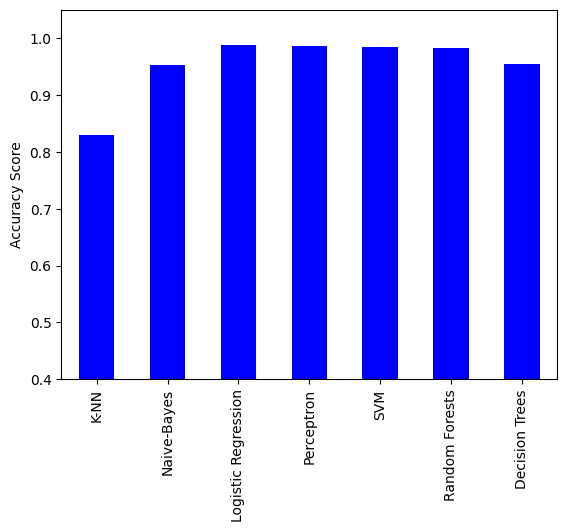

In [44]:
# Visualize traditional machine learning medels' accuracy
ML_model_accuracy = {
    'K-NN': 0.8289,
    'Naive-Bayes': 0.9530,
    'Logistic Regression': 0.9878,
    'Perceptron': 0.9865,
    'SVM': 0.9852,
    'Random Forests': 0.9829,
    'Decision Trees': 0.9542
}
pd.Series(ML_model_accuracy).plot(kind='bar',color='blue')
plt.ylabel('Accuracy Score')
plt.ylim((0.40, 1.05));

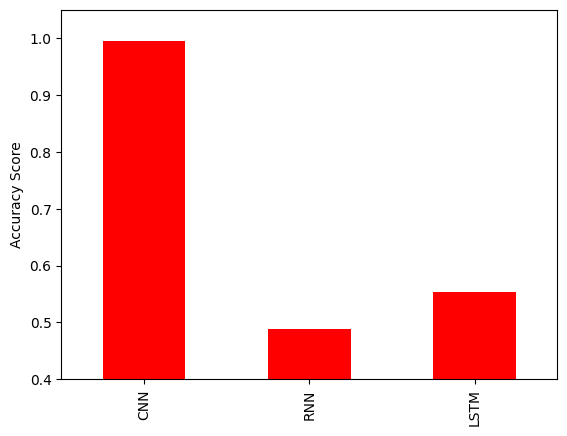

In [45]:
# Visualize Deep learning medels' accuracy
DL_model_accuracy = {
    'CNN': 0.9955,
    'RNN': 0.4883,
    'LSTM': 0.5527,
}
pd.Series(DL_model_accuracy).plot(kind='bar',color='red')
plt.ylabel('Accuracy Score')
plt.ylim((0.40, 1.05));